# Installing / Importing Libraries

In [279]:
import pandas as pd
import numpy as np
from datetime import datetime, date 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  

In [280]:
matplotlib.rcParams['figure.figsize'] = (10,5)

# Data Exploration

In [281]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
df_Inquiries = pd.read_csv(path+'/CallCenter_Inquiries.csv', sep=',', header=0, parse_dates=True)
df_Inquiries

MemoryError: Unable to allocate 1.56 GiB for an array with shape (7, 29888785) and data type int64

In [ ]:
path = 'C:/Users/manal/Desktop/Thesis/Manali-CallsPrediction/ml-generic-thesis-project-structure-main/01-raw-data'
Daily_data = pd.read_csv(path+'/Daily_data.csv', sep=',', header=0, parse_dates=True)
Daily_data

,date,Inquiries_NonStat,Inquiries_Stat
0,2017-01-01,7574.0,NaN
1,2017-01-02,13189.0,NaN
2,2017-01-03,24678.0,NaN
3,2017-01-04,23380.0,1.320733
4,2017-01-05,22809.0,1.247026
...,...,...,...
2095,2022-09-27,11598.0,1.178299
2096,2022-09-28,11886.0,1.298347
2097,2022-09-29,11772.0,NaN
2098,2022-09-30,10669.0,NaN


In [ ]:
Daily_data.set_index('date', inplace = True)
Daily_data.isna().any()

Inquiries_NonStat    False
Inquiries_Stat        True
dtype: bool

In [ ]:
Daily_data.describe()

,Inquiries_NonStat,Inquiries_Stat
count,2100.000000,2094.000000
mean,14234.188571,0.998492
std,5816.090211,0.328633
min,96.000000,0.038536
25%,9733.750000,0.599834
50%,13863.500000,1.145044
75%,19307.000000,1.233318
max,30619.000000,2.227288


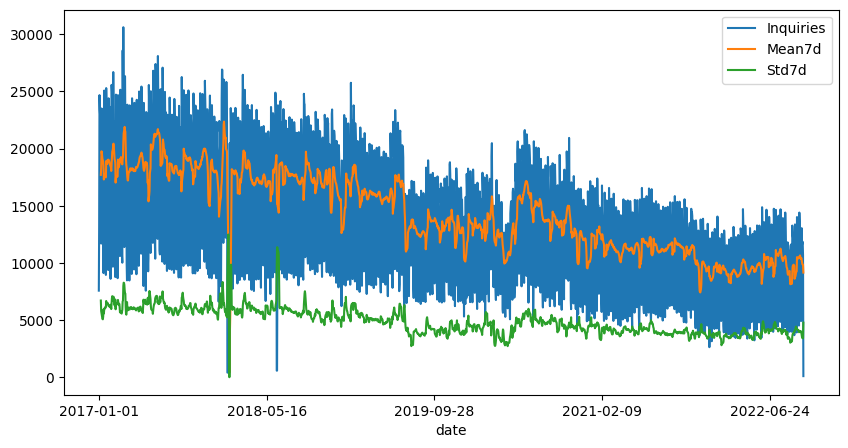

In [ ]:
Daily_data['Inquiries_NonStat'].plot(label='Inquiries')
Daily_data.rolling(window=7).mean()['Inquiries_NonStat'].plot(label='Mean7d')
Daily_data.rolling(window=7).std()['Inquiries_NonStat'].plot(label='Std7d')
plt.legend()

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        if(dfoutput['Test Statistic'] <= dfoutput['Critical Value (%s)'%key] ):
            print('Stationary')
        else:
            print('Non-Stationary')
    print ()
    print (dfoutput)
    print ()
    
adf_test(Daily_data['Inquiries_NonStat'].dropna()) 
# Test Statistics > Critical value (Should be TS <= CV to reject)
# p-value  0.05 (Should be p-value <= significance level to reject)

# Failed to Reject Null hypothesis -- > Non-Stationary data 

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
        if(kpss_output['Test Statistic'] > kpss_output['Critical Value (%s)'%key] ):
            print('Non-Stationary')
        else:
            print('Stationary')
    print ()
    print (kpss_output)
    print ()
kpss_test(Daily_data['Inquiries_NonStat'].dropna())
# Test Statistics > Critical value (Should be TS > CV to reject)
# p-value < 0.05 (Should be p-value > significance level to reject)
# Rejected Null hypothesis -- > Non stationary data 

Results of Dickey-Fuller Test:
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic                   -1.971946
p-value                           0.299008
#Lags Used                       26.000000
Number of Observations Used    2073.000000
Critical Value (1%)              -3.433508
Critical Value (5%)              -2.862935
Critical Value (10%)             -2.567513
dtype: float64

Results of KPSS Test:
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic           10.122761
p-value                   0.010000
#Lags Used               17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64



C:\Users\manal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


ADF test & KPSS test --> Non-Stationary

# Removing Non-Stationarity

1. Log

count    2100.000000
mean        9.454532
std         0.526026
min         4.564348
25%         9.183354
50%         9.537015
75%         9.868223
max        10.329376
Name: Inquiries_NonStat, dtype: float64

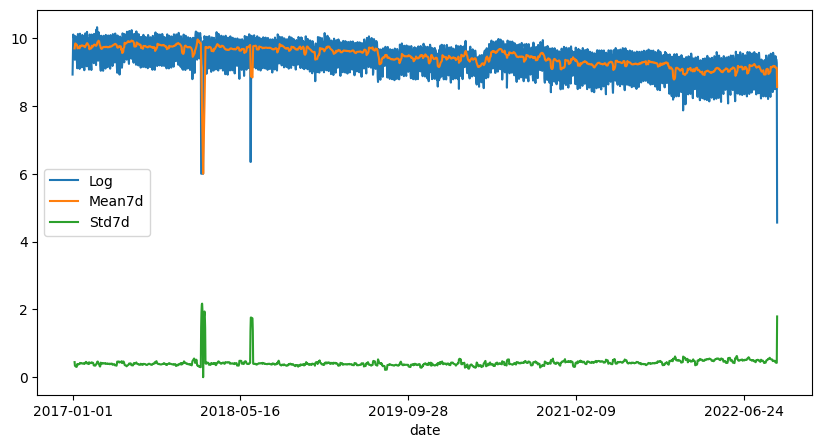

In [ ]:
day_log = np.log(Daily_data['Inquiries_NonStat'])
day_log.plot(label='Log')
day_log.rolling(window=7).mean().plot(label='Mean7d')
day_log.rolling(window=7).std().plot(label='Std7d')
plt.legend()
day_log.describe()

<AxesSubplot: ylabel='Density'>

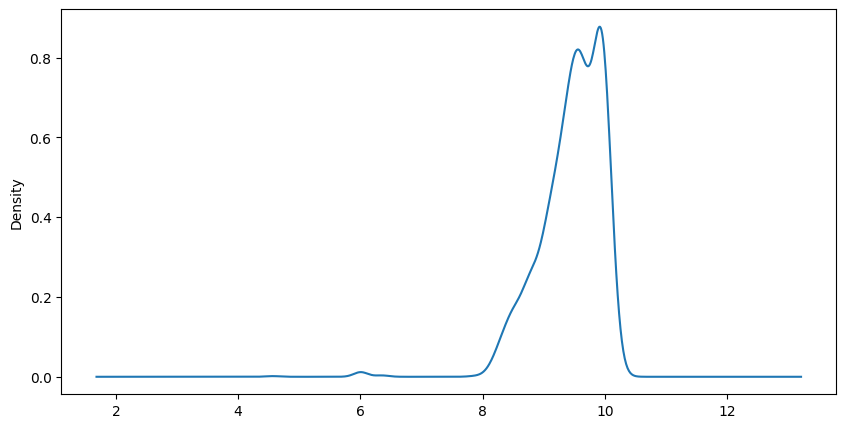

In [ ]:
day_log.plot.density()

In [ ]:
#%pip install statsmodels
day_log['date'] = pd.to_datetime(day_log['date'])
day_log = day_log.set_index('date')
day_log

,Inquiries_NonStat
date,
2017-01-01,8.932477
2017-01-02,9.487138
2017-01-03,10.113667
2017-01-04,10.059636
2017-01-05,10.034910
...,...
2022-09-27,9.358588
2022-09-28,9.383117
2022-09-29,9.373479


In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        if(dfoutput['Test Statistic'] <= dfoutput['Critical Value (%s)'%key] ):
            print('Stationary')
        else:
            print('Non-Stationary')
    print ()
    print (dfoutput)
    print ()
    
adf_test(day_log.dropna()) 
# Test Statistics > Critical value (Should be TS <= CV to reject)
# p-value  0.05 (Should be p-value <= significance level to reject)

# Failed to Reject Null hypothesis -- > Non-Stationary data 

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
        if(kpss_output['Test Statistic'] > kpss_output['Critical Value (%s)'%key] ):
            print('Non-Stationary')
        else:
            print('Stationary')
    print ()
    print (kpss_output)
    print ()
kpss_test(day_log.dropna())
# Test Statistics > Critical value (Should be TS > CV to reject)
# p-value < 0.05 (Should be p-value > significance level to reject)
# Rejected Null hypothesis -- > Non stationary data 

Results of Dickey-Fuller Test:
Non-Stationary
Non-Stationary
Stationary

Test Statistic                   -2.696053
p-value                           0.074724
#Lags Used                       26.000000
Number of Observations Used    2073.000000
Critical Value (1%)              -3.433508
Critical Value (5%)              -2.862935
Critical Value (10%)             -2.567513
dtype: float64

Results of KPSS Test:
Non-Stationary
Non-Stationary
Non-Stationary
Non-Stationary

Test Statistic            8.763468
p-value                   0.010000
#Lags Used               15.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64



C:\Users\manal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


ADF test --> Stationary
KPSS test --> Non-Stationary
## https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/
Types of Stationarity

Case 1: Both tests conclude that the series is not stationary -> series is not stationary
Case 2: Both tests conclude that the series is stationary -> series is stationary
Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

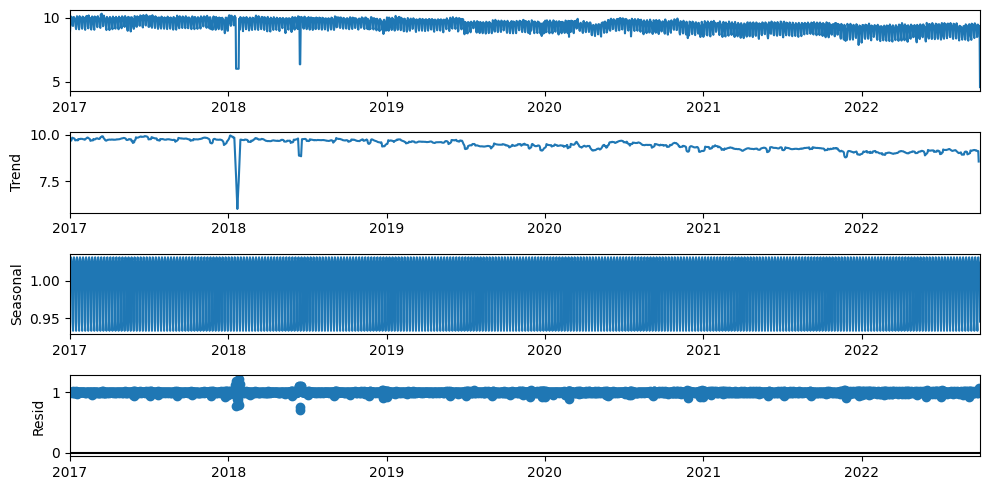

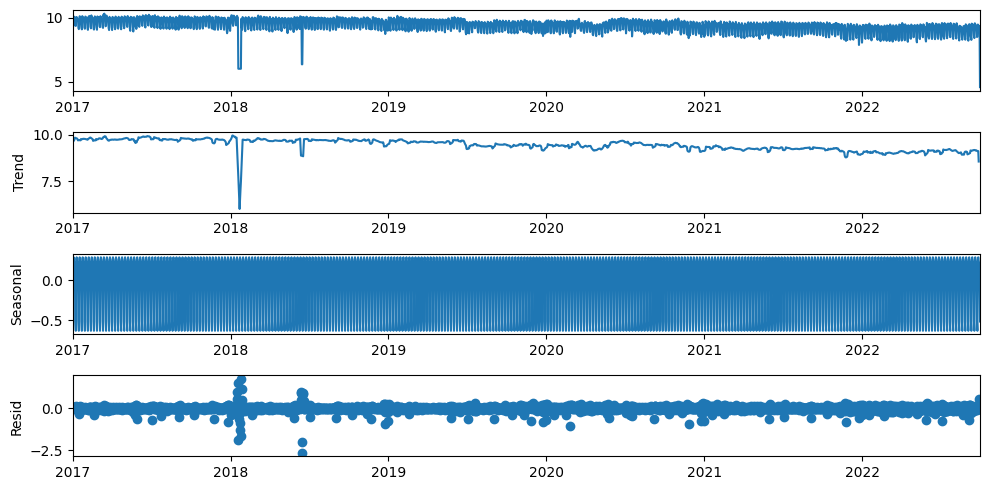

In [ ]:
#day_log = day_log.reset_index('date')
#Stats_Univariate_data111 = Stats_Univariate_data.loc['2018-01-01':'2019-01-01']#.set_index('date')
res2 = seasonal_decompose(day_log, model='multipicative') # T*S*R = Observed
resplot = res2.plot()
res2 = seasonal_decompose(day_log, model='additive') # T*S*R = Observed
resplot = res2.plot()

2. Differencing

In [ ]:
#First order
day_log_diff = day_log.diff()
day_log_diff.describe()

,Inquiries_NonStat
count,2099.000000
mean,-0.002081
std,0.494788
min,-4.710749
25%,-0.144618
50%,-0.062100
75%,0.009811
max,3.920069


In [ ]:
#Second order
day_log_diff_2 = day_log.diff().diff()
day_log_diff_2.describe()

,Inquiries_NonStat
count,2098.000000
mean,-0.002510
std,0.699570
min,-4.612368
25%,-0.507684
50%,-0.008848
75%,0.457048
max,4.011801


In [ ]:
#Third order
day_log_diff_3 = day_log.diff().diff().diff()
day_log_diff_3.describe()

,Inquiries_NonStat
count,2097.000000
mean,-0.002234
std,1.128715
min,-8.523463
25%,-0.464875
50%,0.031285
75%,0.857373
max,8.008734


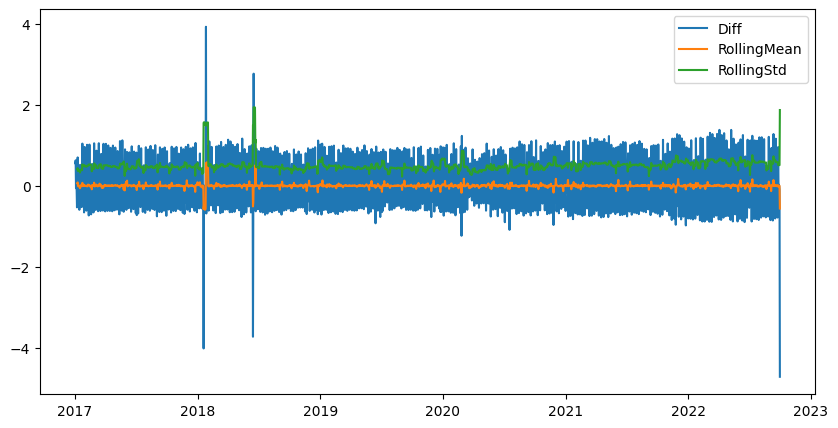

In [ ]:
plt.plot(day_log_diff,label='Diff')

plt.plot(day_log_diff.rolling(window=7).mean(),label='RollingMean')
plt.plot(day_log_diff.rolling(window=7).std(),label='RollingStd')
plt.legend()

Stationarity CHeck

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        if(dfoutput['Test Statistic'] <= dfoutput['Critical Value (%s)'%key] ):
            print('Stationary')
        else:
            print('Non-Stationary')
    print ()
    print (dfoutput)
    print ()
    
adf_test(day_log_diff.dropna()) 
# Test Statistics > Critical value (Should be TS <= CV to reject)
# p-value  0.05 (Should be p-value <= significance level to reject)

# Failed to Reject Null hypothesis -- > Non-Stationary data 

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
        if(kpss_output['Test Statistic'] > kpss_output['Critical Value (%s)'%key] ):
            print('Non-Stationary')
        else:
            print('Stationary')
    print ()
    print (kpss_output)
    print ()
kpss_test(day_log_diff.dropna())
# Test Statistics > Critical value (Should be TS > CV to reject)
# p-value < 0.05 (Should be p-value > significance level to reject)
# Rejected Null hypothesis -- > Non stationary data 

Results of Dickey-Fuller Test:
Stationary
Stationary
Stationary

Test Statistic                -1.691502e+01
p-value                        1.003954e-29
#Lags Used                     2.600000e+01
Number of Observations Used    2.072000e+03
Critical Value (1%)           -3.433510e+00
Critical Value (5%)           -2.862936e+00
Critical Value (10%)          -2.567513e+00
dtype: float64

Results of KPSS Test:
Stationary
Stationary
Stationary
Stationary

Test Statistic            0.213641
p-value                   0.100000
#Lags Used               59.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64



C:\Users\manal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Strict Stationary

 # Autocorrelation Plots

In [ ]:
# %pip install pmdarima

In [ ]:
from pmdarima.arima.utils import ndiffs  
X = day_log 
  
# Augmented Dickey Fuller Test  
adftest = ndiffs(X, test = 'adf')  
  
# KPSS Test  
kpsstest = ndiffs(X, test = 'kpss')  
  
# PP Test  
pptest = ndiffs(X, test = 'pp')  
  
print("ADF Test =", adftest)  
print("KPSS Test =", kpsstest)  
print("PP Test =", pptest)  

ADF Test = 0
KPSS Test = 1
PP Test = 0


C:\Users\manal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\manal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\manal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\graphics\tsaplots.py:348:

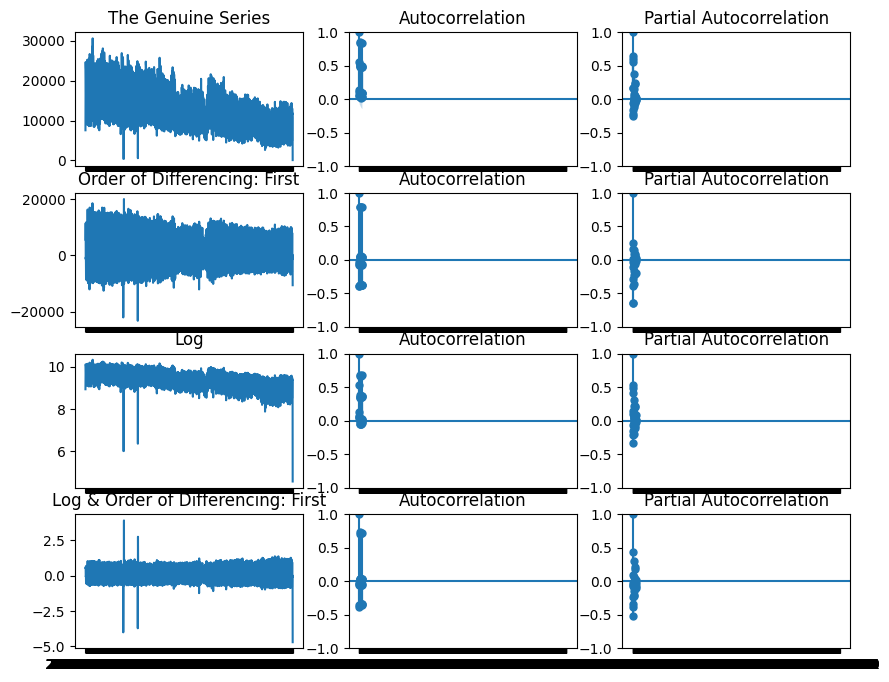

In [ ]:
df = pd.DataFrame(Daily_data['Inquiries_NonStat'])
matplotlib.rcParams['figure.figsize'] = (10,8)

# The Genuine Series  
fig, axes = plt.subplots(4, 3, sharex = True)  
axes[0, 0].plot(df); axes[0, 0].set_title('The Genuine Series')  
plot_acf(df, ax = axes[0, 1])  
plot_pacf(df, ax = axes[0, 2])  
  
# Order of Differencing: First  
axes[1, 0].plot(df.diff()); axes[1, 0].set_title('Order of Differencing: First')  
plot_acf(df.diff().dropna(), ax = axes[1, 1])  
plot_pacf(df.diff().dropna(), ax = axes[1, 2])  
  
# Order of Differencing: Second  
axes[2, 0].plot(np.log(df)); axes[2, 0].set_title('Log')  
plot_acf(np.log(df).dropna(), ax = axes[2, 1]) 
plot_pacf(np.log(df).dropna(), ax = axes[2, 2])  

# Order of Differencing: Second  
axes[3, 0].plot(np.log(df).diff()); axes[3, 0].set_title('Log & Order of Differencing: First')  
plot_acf(np.log(df).diff().dropna(), ax = axes[3, 1]) 
plot_pacf(np.log(df).diff().dropna(), ax = axes[3, 2]) 


plt.show()  

# Order of AR, I, MA

Order of AR (from Autocorrelation) --> 2

Order of MA (from Partial Autocorrelation) --> 2

p,d,q

2,0,2


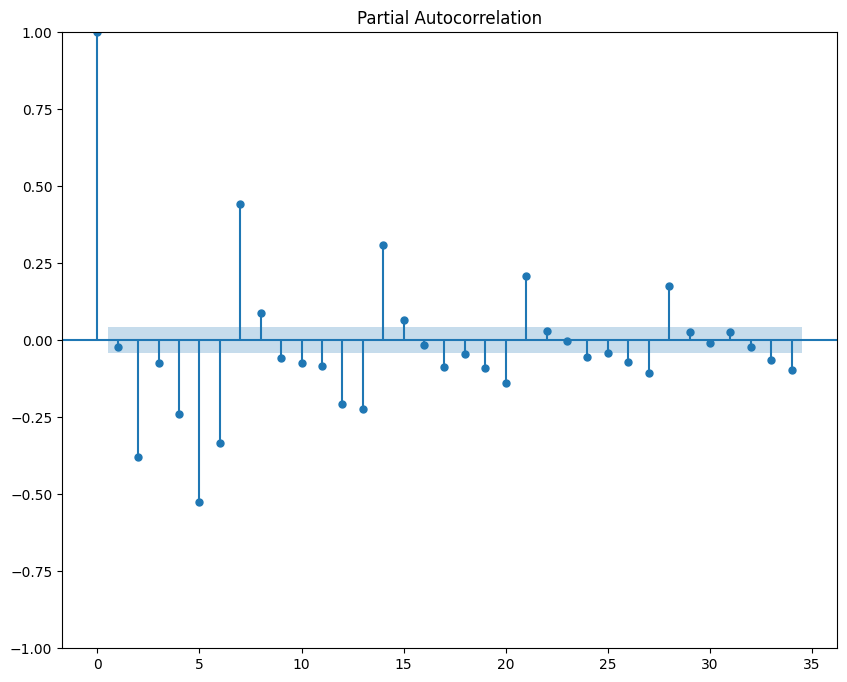

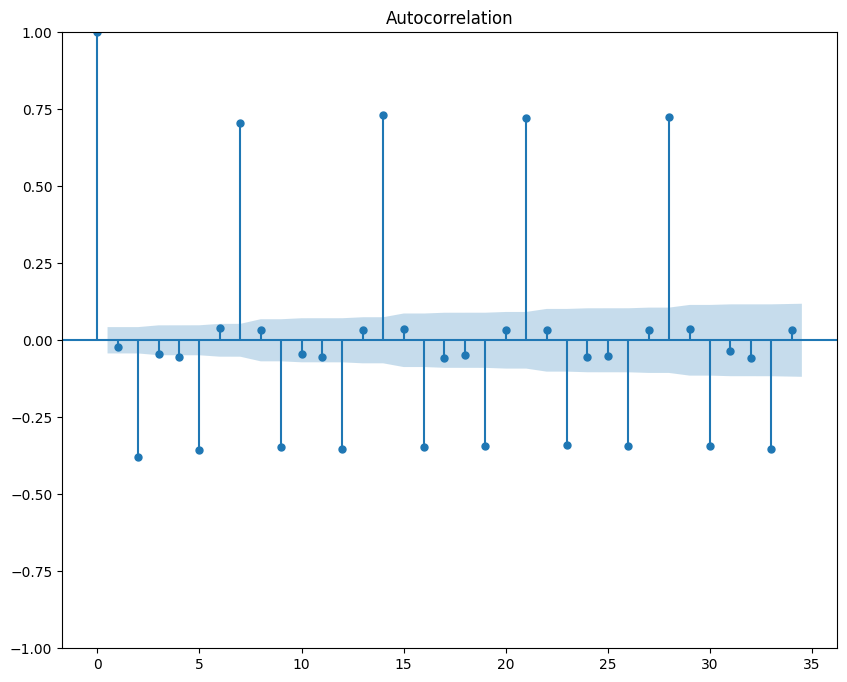

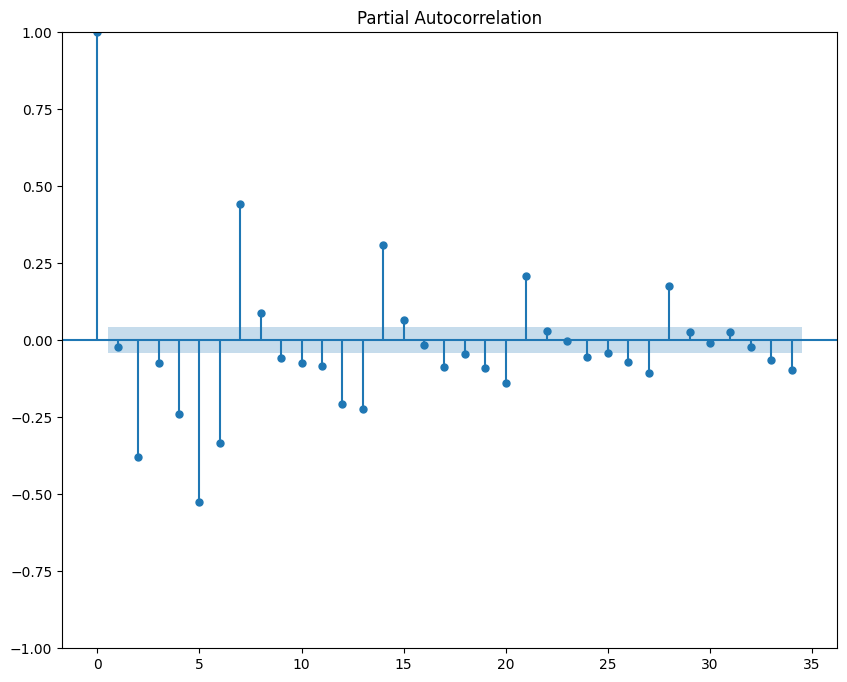

In [ ]:
plot_acf(np.log(df).diff().dropna())
plot_pacf(np.log(df).diff().dropna()) 

# ARIMA(2,0,2)

In [286]:
from statsmodels.tsa.arima.model import ARIMA

C:\Users\manal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:      Inquiries_NonStat   No. Observations:                 2100
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1080.328
Date:                Fri, 16 Dec 2022   AIC                           2170.656
Time:                        15:31:40   BIC                           2198.902
Sample:                    01-01-2017   HQIC                          2181.002
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6073      0.016     38.609      0.000       0.576       0.638
ar.L2         -0.3480      0.018    -19.073      0.000      -0.384      -0.312
ma.L1         -1.9781      0.004   -448.036      0.0

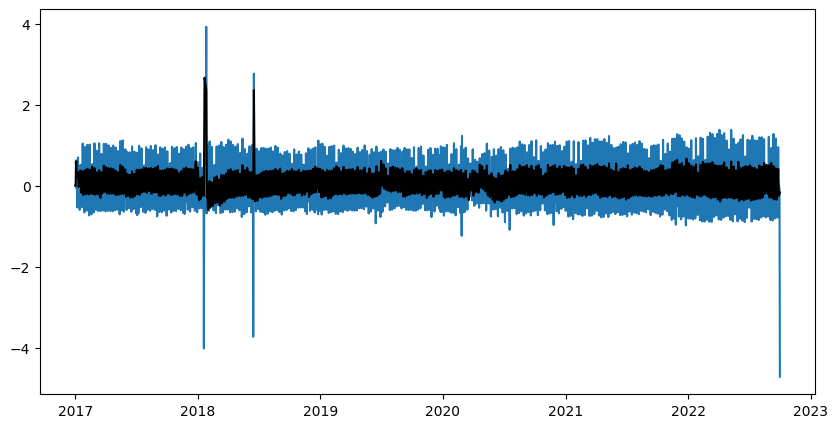

In [287]:
model = ARIMA(day_log_diff, order = (2,1,2), freq='D')
results_ARIMA = model.fit()
plt.plot(day_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='black')
print(results_ARIMA.summary())

# Original Scale of predicted data

In [288]:
# Predictions
ARIMA_diff_predictions = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(ARIMA_diff_predictions.head())

date
2017-01-01    0.000000
2017-01-02    0.000000
2017-01-03    0.554662
2017-01-04    0.602521
2017-01-05    0.234699
dtype: float64


In [289]:
# Differencing 
ARIMA_diff_predictions_cumsum = ARIMA_diff_predictions.cumsum()
print(ARIMA_diff_predictions_cumsum.head())

date
2017-01-01    0.000000
2017-01-02    0.000000
2017-01-03    0.554662
2017-01-04    1.157183
2017-01-05    1.391882
dtype: float64


In [315]:
ARIMA_log_predictions = pd.Series(day_log.iloc[0],day_log.index)

ARIMA_log_predictions = ARIMA_log_predictions.add(ARIMA_diff_predictions.cumsum(), fill_value = 0)

print(ARIMA_log_predictions.head())

date
2017-01-01    0.000000
2017-01-02    0.000000
2017-01-03    0.554662
2017-01-04    1.157183
2017-01-05    1.391882
dtype: float64


In [368]:
ARIMA_predictions = np.exp(ARIMA_log_predictions)
ARIMA_predictions_df = pd.DataFrame(ARIMA_predictions,columns = ['Inquiries'])
ARIMA_predictions_df

,Inquiries
date,
2017-01-01,1.000000
2017-01-02,1.000000
2017-01-03,1.741352
2017-01-04,3.180959
2017-01-05,4.022414
...,...
2022-09-27,5946.957263
2022-09-28,4652.470496
2022-09-29,3776.236228


In [369]:
Daily_data = pd.DataFrame(Daily_data)
orig = Daily_data.drop(columns = ['Inquiries_Stat'])

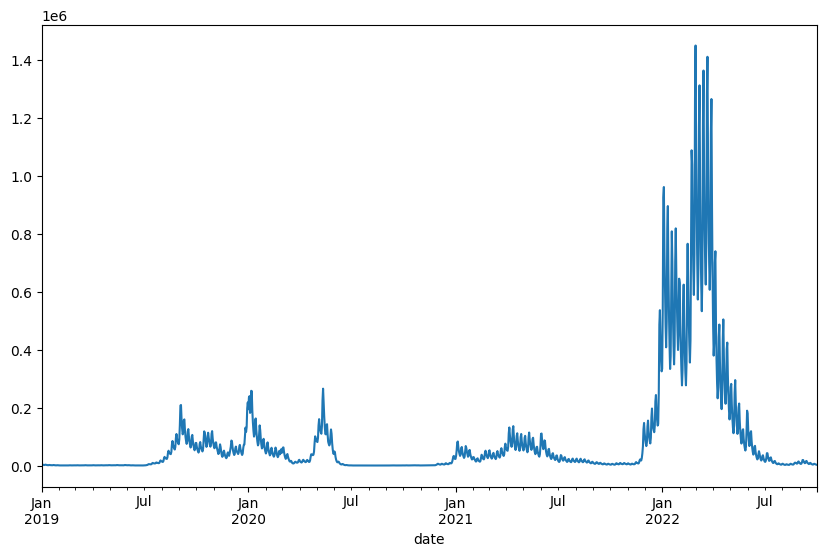

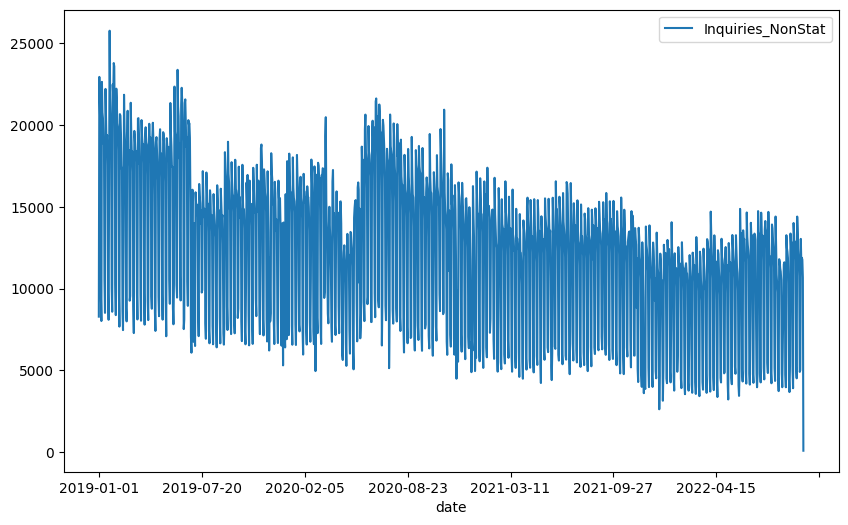

In [376]:
matplotlib.rcParams['figure.figsize'] = (10,6)
ARIMA_predictions.loc['2019-01-01':].plot()
orig.loc['2019-01-01':].plot()

plt.show()  

In [384]:
rms = np.sqrt(mean_squared_error(ARIMA_predictions, orig, squared=False))
rms


34142.74983002371